## Logistic Regression - Titanic

The titanic dataset is a popular dummy dataset used to learn about logistic regression. It has also been used in a [Kaggle data science competition](https://www.kaggle.com/c/titanic), so you'll also find blogposts exploring all kinds of more advanced concepts that use this dataset too! In this assignment, you'll do a logistic regression to look at the effect of sex and class on survival on the titanic, by computing odds ratios.

adapted from: https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-homework.ipynb

Some references:

- [What are odds vs. probability?](https://towcenter.gitbooks.io/curious-journalist-s-guide-to-data/content/analysis/counting_possible_worlds.html)
- [Investigate.ai on Logistic Regressions](https://investigate.ai/regression/logistic-regression-quickstart/)
- [StatQuest Logistic Regressions Playlist](https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)
- [How do I interpret odds ratios in logistic regression?](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/) This one's a little more technical, but has good examples.


In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

require('tidyverse')
require('DescTools')

R[write to console]: Loading required package: tidyverse



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


R[write to console]: Loading required package: DescTools



### Load the data

Read in the `titanic.csv` data set again.

In [4]:
# Load titanic.csv
df = pd.read_csv('titanic.csv')
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender
0,1st,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female
1,1st,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
2,1st,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male
3,1st,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female
4,1st,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NaN,11,male
...,...,...,...,...,...,...,...,...,...,...
1308,3rd,0,"Zakarian, Mr Artun",NaN,NaN,NaN,NaN,NaN,NaN,male
1309,3rd,0,"Zakarian, Mr Maprieder",NaN,NaN,NaN,NaN,NaN,NaN,male
1310,3rd,0,"Zenn, Mr Philip",NaN,NaN,NaN,NaN,NaN,NaN,male
1311,3rd,0,"Zievens, Rene",NaN,NaN,NaN,NaN,NaN,NaN,female


The first thing we need to do is code the pclass and gender variables numerically. Let's use the following scheme:
- pclass: 1,2,3
- gender: 0=male, 1=female, and let's call the column called "female" to remind us which is which

In [5]:
# recode the pclass and gender variables so they are numeric
df['pclass'] = df.pclass.replace({'1st': 1, '2nd': 2, '3rd': 3})
df['female'] = df.gender.replace({'male': 0, 'female': 1})
df.head(3)

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female
0,1,1,"Allen, Miss Elisabeth Walton",29.0,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1
1,1,0,"Allison, Miss Helen Loraine",2.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,NaN,female,1
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0,Southampton,"Montreal, PQ / Chesterville, ON",C26,NaN,-135,male,0


### 1. Exploratory data analysis

In [6]:
df.survived.value_counts()

0    864
1    449
Name: survived, dtype: int64

In [7]:
# What is the chance of survival 

survived = df.survived.value_counts()[1]
survived
chance_of_survival = survived / len(df)
chance_of_survival


0.341964965727342

In [8]:
# What are the odds of survival?
not_survived = df.survived.value_counts()[0]
odds_of_survival = survived / not_survived
odds_of_survival

0.5196759259259259

First, let's do some **descriptive stats**. Our aim in this notebook is to determine what factors impact surival. So let's start by looking at a few pivot tables of `survived` versus factors like `gender` and `pclass`.

In [9]:
# First, let's do some descriptive stats
# 
# How many men and women are travelling on the titanic?
# What share of each survived? What were the odds of survival for each?
piv = df.pivot_table(index='survived', columns='female', aggfunc='count', values='name')
display(piv)

print("Percent chance of survival for women vs men")
display(pd.DataFrame(piv.iloc[1,:] / piv.sum(), columns=['Percent Survived']))
print("Men had only about a 17 percent chance of survival")
print("Women had a 66 percent chance of surviving the Titanic.")


print("\nOdds of survival for women vs men")
display(pd.DataFrame(piv.iloc[1,:] / piv.iloc[0,:], columns=['Odds Survived']))
print("Odds of a man surviving are 1 to 5")
print("Odds of a woman surviving are approximately 2 to 1")

female,0,1
survived,,
0,708,156
1,142,307


Percent chance of survival for women vs men


,Percent Survived
female,
0,0.167059
1,0.663067


Men had only about a 17 percent chance of survival
Women had a 66 percent chance of surviving the Titanic.

Odds of survival for women vs men


,Odds Survived
female,
0,0.200565
1,1.967949


Odds of a man surviving are 1 to 5
Odds of a woman surviving are approximately 2 to 1


Now do the same for `pclass`. 
- How many people are travelling in each class? 
- What are the odds of survival for each class? 
- The probability of survival?

In [10]:
print("How many people are travelling in each class?")
display(pd.crosstab(df.pclass, df.survived, margins=True))

How many people are travelling in each class?


survived,0,1,All
pclass,,,
1,129,193,322
2,161,119,280
3,574,137,711
All,864,449,1313


In [11]:
# 👉 Calculate the odds of survival for each class 
# (hint: you can copy/paste code from the section above)


piv_2 = df.pivot_table(index='survived', columns='pclass', aggfunc='count', values='name')
display(piv_2)


print("\nOdds of survival for each class:")
display(pd.DataFrame(piv_2.iloc[1,:] / piv_2.iloc[0,:], columns=['Odds Survived']))


pclass,1,2,3
survived,,,
0,129,161,574
1,193,119,137



Odds of survival for each class:


,Odds Survived
pclass,
1,1.496124
2,0.739130
3,0.238676


In [12]:
# 👉 Calculate the probability of survival for each class 
# (hint: you can copy/paste code from the section above)

print("\nProbability of survival for each class:")
display(pd.DataFrame(piv_2.iloc[1,:] / piv_2.sum(), columns=['Probability Survived']))



Probability of survival for each class:


,Probability Survived
pclass,
1,0.599379
2,0.425000
3,0.192686


### 2. Logistic regression with one variable at a time

First, do a logistic regression of the `female` variable alone to predict the probability of survival. Below is some code that will help you plot the result.

**Step 1: Run a logistic regression on one variable and see the summary of the output**


In [13]:
%%R -i df
logistic <- glm(survived ~ female, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = survived ~ female, family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4750  -0.6046  -0.6046   0.9065   1.8918  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.60662    0.09195  -17.47   <2e-16 ***
female       2.28361    0.13462   16.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1686.8  on 1312  degrees of freedom
Residual deviance: 1358.7  on 1311  degrees of freedom
AIC: 1362.7

Number of Fisher Scoring iterations: 4



Looks like gender does provide us some information about whether or not someone will survive. We'll come back to the outputs of the logistic regression. You can't read it exactly like a linear regression (notice the lack of an R^2 value). That's because logistic regressions don't have residuals. You'll learn more about this in the StatQuest. For now, let's make some predictions using this very simple model.

In [64]:
%%R

library("PseudoR2")
# The model evaluation criteria in the output above is the AIC. But we don't know much about those yet.
# Here is one that might look more familiar. It's not exactly an R^2, but it can be interpreted similarly.
# https://search.r-project.org/CRAN/refmans/DescTools/html/PseudoR2.html
# https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/

PseudoR2(logistic, which="McFadden")

R[write to console]: Error in library("PseudoR2") : there is no package called ‘PseudoR2’




Error in library("PseudoR2") : there is no package called ‘PseudoR2’


RInterpreterError: Failed to parse and evaluate line '\nlibrary("PseudoR2")\n# # The model evaluation criteria in the output above is the AIC. But we don\'t know much about those yet.\n# # Here is one that might look more familiar. It\'s not exactly an R^2, but it can be interpreted similarly.\n# # https://search.r-project.org/CRAN/refmans/DescTools/html/PseudoR2.html\n# # https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/\n\n# PseudoR2(logistic, which="McFadden")\n'.
R error message: 'Error in library("PseudoR2") : there is no package called ‘PseudoR2’'

**Step 2: analyze the dataframe with predicted values**


In [15]:
%%R -o df

df <- df %>% mutate(
    prediction = exp(predict(logistic))
)

In [16]:
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,1.967949
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NA_character_,NA_character_,female,1,1.967949
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NA_character_,-135,male,0,0.200565
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NA_character_,NA_character_,female,1,1.967949
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NA_character_,11,male,0,0.200565
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,male,0,0.200565
1309,3,0,"Zakarian, Mr Maprieder",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,male,0,0.200565
1310,3,0,"Zenn, Mr Philip",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,male,0,0.200565
1311,3,0,"Zievens, Rene",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,female,1,1.967949


Hmm...interesting. There are only two possible outcomes for the prediction (which in the case of logistic regression is the chance that someone will survive). 

In [17]:
odds = df.prediction.unique()
odds

array([1.96794872, 0.20056497])

In [18]:
probabilities = odds / (1 + odds)
probabilities.round(2)

array([0.66, 0.17])

That makes sense though. The only thing this model considers is whether or not someone is female. On that basis it can only make two possible predictions.

Also, don't those numbers look familiar? .66 and .17 are the values from the pivot table ‼️ BAM!

In this simple one-variable case, the logistic regression predictions are simply the probabilities of survival for men and women.

**Step 3: What is the odds ratio of on the gender variable alone?**

In [19]:
# odds of survival for women / odds of surival for men
odds[0] / odds[1]

9.812026002165782

In [20]:
%%R 

coef(logistic)

(Intercept)      female 
  -1.606617    2.283609 


In [21]:
%%R

exp(coef(logistic))

(Intercept)      female 
   0.200565    9.812026 


The `coef` is the log of the odds ratio. We exponentiate that to get the odds ratio of 9.8

So in this simple model, the odds of survival are 9.8 times higher for women than men.



In [22]:
print("What share of each survived? \n(probability)")
display(pd.crosstab(df.gender, df.survived, margins=True, normalize='index').round(2).iloc[: ,1:])

print("What share of each survived? \n(odds)")
display(
    pd.crosstab(df.gender, df.survived).iloc[: ,1] / pd.crosstab(df.gender, df.survived).iloc[: ,0]
)

What share of each survived? 
(probability)


survived,1
gender,
female,0.66
male,0.17
All,0.34


What share of each survived? 
(odds)


gender
female    1.967949
male      0.200565
dtype: float64

WHOA! the odds of survival are 1.97 for women and .2 for men

And the odds ratio is 🥁🥁🥁🥁🥁🥁 1.97/.2 = 9.81

Same as the Logistic Regression!!! 

So in this simple one variable case...the logistic regression isn't doing much more than simple probability calculations!

**Now, try the same thing but with the `pclass` variable**

In [62]:
%%R -i df

# Step 1: Run a logistic regression on one variable and see the summary of the output
# 👉 hint: you can copy/paste code from the section above

logistic_2 <- glm(survived ~ factor(pclass), data=df, family="binomial")
summary(logistic_2)


Call:
glm(formula = survived ~ factor(pclass), family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3526  -0.6543  -0.6543   1.0118   1.8148  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)       0.4029     0.1137   3.543 0.000396 ***
factor(pclass)2  -0.7052     0.1660  -4.249 2.15e-05 ***
factor(pclass)3  -1.8355     0.1482 -12.382  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1686.8  on 1312  degrees of freedom
Residual deviance: 1512.3  on 1310  degrees of freedom
AIC: 1518.3

Number of Fisher Scoring iterations: 4



In [59]:
%%R -i df

# Step 2: analyze the dataframe with predicted values
# 👉 hint: you can copy/paste code from the section above

df <- df %>% mutate(
      predicted_logodds = exp(predict(logistic_2)), 
      predicted_odds = predicted_logodds / (1 + predicted_logodds), 
      predicted_probability = predicted_odds / (1 + predicted_odds)
)


In [60]:
%%R -i df

summary(logistic_2)

exp(coef(logistic_2))

(Intercept)      pclass 
  4.0536798   0.3951334 


In [63]:
%%R

exp(coef(logistic_2))

    (Intercept) factor(pclass)2 factor(pclass)3 
      1.4961240       0.4940302       0.1595295 


In [26]:
# Step 3: What is the odds ratio of on the pclass variable alone?
# 👉 hint: you can copy/paste code from the section above, remember in order to make sense of the 
#          coefficients, you'll need to exponentiate them. That turns the coefficients into odds ratios.

odds = df.prediction.unique()
odds

array([1.96794872, 0.20056497])

### 3. Looking at two variables at a time

We know from the earlier assignment that class also affects survival, so let's add that to our model. Compute a logistic regression on the variables `pclass` and `female`.

In [35]:
%%R -i df

# Logistic regression on two variables

logistic <- glm(survived ~ pclass + female, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = survived ~ pclass + female, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0677  -0.6481  -0.3989   0.5010   2.2674  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.6210     0.1957   3.173  0.00151 ** 
pclass       -1.0373     0.0880 -11.788  < 2e-16 ***
female        2.4285     0.1507  16.118  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1686.8  on 1312  degrees of freedom
Residual deviance: 1202.0  on 1310  degrees of freedom
AIC: 1208

Number of Fisher Scoring iterations: 4



In [37]:
%%R 

PseudoR2(logistic, which="McFadden")

R[write to console]: Error in PseudoR2(logistic, which = "McFadden") : 
  could not find function "PseudoR2"




Error in PseudoR2(logistic, which = "McFadden") : 
  could not find function "PseudoR2"


RInterpreterError: Failed to parse and evaluate line '\nPseudoR2(logistic, which="McFadden")\n'.
R error message: 'Error in PseudoR2(logistic, which = "McFadden") : \n  could not find function "PseudoR2"'

Both variables have a significant p-value, the pseudo R-squared is better...meaning we have a better representation of the odds of survival with this model! Looks like considering both age and class of a person together give us a better representation of whether or not they will survive.

In [38]:
%%R -o df

# Step 2: analyze the dataframe with predicted values

df <- df %>% mutate(prediction = exp(predict(logistic)))

In [46]:
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,7.479252
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NA_character_,NA_character_,female,1,7.479252
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NA_character_,-135,male,0,0.659449
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,NA_character_,NA_character_,female,1,7.479252
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,NA_character_,11,male,0,0.659449
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,3,0,"Zakarian, Mr Artun",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,male,0,0.082830
1309,3,0,"Zakarian, Mr Maprieder",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,male,0,0.082830
1310,3,0,"Zenn, Mr Philip",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,male,0,0.082830
1311,3,0,"Zievens, Rene",NaN,NA_character_,NA_character_,NA_character_,NA_character_,NA_character_,female,1,0.939433


Now there are several predicted values...six to be exact! 

3 classes x 2 genders = 6 possible predictions

In [47]:
df.prediction.unique()

array([7.47925182, 0.65944902, 0.23371415, 2.6507083 , 0.08283021,
       0.9394328 ])

In [48]:
%%R 
# Step 3: What is the odds ratio of on the gender variable?

# hint: in order to make sense of the coefficients, you'll need to exponentiate them
# that turns the coefficients into odds ratios
# https://investigate.ai/regression/logistic-regression-quickstart/#Converting-coefficient-to-odds

coef(logistic)

(Intercept)      pclass      female         age 
 2.81880543 -1.42240121  3.08618761 -0.04886694 


In [49]:
%%R 
exp(coef(logistic))

(Intercept)      pclass      female         age 
 16.7568215   0.2411343  21.8934523   0.9523078 


Now our odds ratio is 11.34 on `female` and `.35` on pclass. The coefficients allow you to compare `pclass` to `female` and the odds ratios allow you to more meaningfully interpret the increase or decrease in odds of survival based on gender or pclass.

### 4. What does this mean

What is the odds ratio on the `pclass` variable? What happens to the odds of survival when we move from 1st to 2nd or from 2nd to 3rd class?


👉 The odds ratio on `female` was 9.8 for the model `survived ~ female`

👉 The odds ratio on `female` was 11.34 for the model `survived ~ pclass + female` (which does a better job at explaining the variance in who survived or not because it has a higher Pseudo R-squared)

This means that when we **control for** the effect of class, the gender disparity chances of surival increases. Women are more likely to surive than we had originally thought.

But are ticket class and gender the only things that determine your chance of survival?

In [54]:
%%R 



     pclass survived
0         1        1
1         1        0
2         1        0
3         1        0
4         1        1
5         1        1
6         1        1
7         1        0
8         1        1
9         1        0
10        1        0
11        1        1
12        1        1
13        1        1
14        1        0
15        1        1
16        1        0
17        1        0
18        1        1
19        1        1
20        1        1
21        1        0
22        1        1
23        1        1
24        1        1
25        1        0
26        1        1
27        1        1
28        1        1
29        1        0
30        1        1
31        1        1
32        1        1
33        1        0
34        1        0
35        1        0
36        1        1
37        1        1
38        1        1
39        1        0
40        1        1
41        1        1
42        1        1
43        1        1
44        1        0
45        1        0
46        1  

### 5. Bonus - Age

Does the age of a passenger impact their chances of survival?

[1] "What about age? Were older people more likely to survive than younger people"


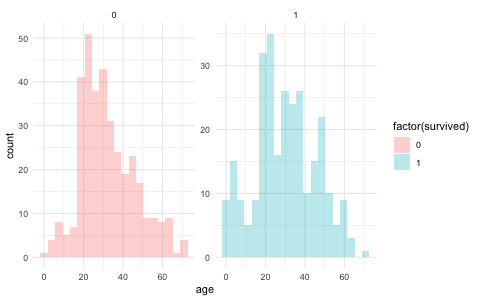

In [50]:
%%R -h 300
# Since age is a continous variable..the pivot tables we used above aren't too helpful anymore
print("What about age? Were older people more likely to survive than younger people")
ggplot(df %>% drop_na(age)) + 
    aes(x=age, fill=factor(survived)) + 
    geom_histogram(alpha=.3, bins=20) + 
    facet_wrap(~survived, scales='free_y') + 
    theme_minimal()


Hmm...the histograms look quite similar...**EXCEPT** what is that bump on the left side among survivors? Looks a bigger share of a the survivors are children than the non-survivors.

Let's explore this phenomenon in the context of the other variables (in our Logistic Regression!)

In [51]:
%%R -i df

# Logistic regression on two variables

logistic <- glm(survived ~ pclass + female + age, data=df, family="binomial")
summary(logistic)


Call:
glm(formula = survived ~ pclass + female + age, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9655  -0.6657  -0.3099   0.5814   2.7104  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.818805   0.501547   5.620 1.91e-08 ***
pclass      -1.422401   0.169601  -8.387  < 2e-16 ***
female       3.086188   0.241293  12.790  < 2e-16 ***
age         -0.048867   0.008614  -5.673 1.40e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 869.54  on 632  degrees of freedom
Residual deviance: 539.82  on 629  degrees of freedom
  (680 observations deleted due to missingness)
AIC: 547.82

Number of Fisher Scoring iterations: 5



In [52]:
%%R 
PseudoR2(logistic, which="McFadden")

R[write to console]: Error in PseudoR2(logistic, which = "McFadden") : 
  could not find function "PseudoR2"




Error in PseudoR2(logistic, which = "McFadden") : 
  could not find function "PseudoR2"


RInterpreterError: Failed to parse and evaluate line 'PseudoR2(logistic, which="McFadden")\n'.
R error message: 'Error in PseudoR2(logistic, which = "McFadden") : \n  could not find function "PseudoR2"'

In [65]:
%%R -i df

# Step 1: Run a logistic regression on one variable and see the summary of the output
# 👉 hint: you can copy/paste code from the section above

logistic_3 <- glm(survived ~ pclass+female, data=df, family="binomial")
summary(logistic_3)


Call:
glm(formula = survived ~ pclass + female, family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0677  -0.6481  -0.3989   0.5010   2.2674  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.6210     0.1957   3.173  0.00151 ** 
pclass       -1.0373     0.0880 -11.788  < 2e-16 ***
female        2.4285     0.1507  16.118  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1686.8  on 1312  degrees of freedom
Residual deviance: 1202.0  on 1310  degrees of freedom
AIC: 1208

Number of Fisher Scoring iterations: 4



In [ ]:
%%R -o df 

df <- df %>% drop_na(age) # note that we're dropping about half the dataframe here!!!!!
df <- df %>% mutate(
    prediction = exp(predict(logistic)),
    prediction_pct = prediction / (1 + prediction)
)


In [ ]:
df

,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,gender,female,prediction,prediction_pct
0,1,1,"Allen, Miss Elisabeth Walton",29.0000,Southampton,"St Louis, MO",B-5,24160 L221,2,female,1,21.444123,0.955445
1,1,0,"Allison, Miss Helen Loraine",2.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,None,None,female,1,80.226827,0.987689
2,1,0,"Allison, Mr Hudson Joshua Creighton",30.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,None,-135,male,0,0.932763,0.482606
3,1,0,"Allison, Mrs Hudson J.C. (Bessie Waldo Daniels)",25.0000,Southampton,"Montreal, PQ / Chesterville, ON",C26,None,None,female,1,26.073472,0.963063
4,1,1,"Allison, Master Hudson Trevor",0.9167,Southampton,"Montreal, PQ / Chesterville, ON",C22,None,11,male,0,3.863633,0.794392
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,3,0,"Gronnestad, Mr Daniel Danielsen",32.0000,Southampton,"Foresvik, Norway Portland, ND",None,None,None,male,0,0.049186,0.046880
835,3,0,"Gustafsson, Mr Alfred Ossian",20.0000,Southampton,"Waukegan, Chicago, IL",None,None,None,male,0,0.088413,0.081231
836,3,0,"Gustafsson, Mr Anders Vilhelm",37.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",None,None,None,male,0,0.038524,0.037095
837,3,0,"Gustafsson, Mr Johan Birger",28.0000,Southampton,"Ruotsinphytaa, Finland New York, NY",None,None,None,male,0,0.059805,0.056430


Since age is a continous variable, we have LOTS of predictions now.

In [ ]:
df.prediction.unique()

array([2.14441232e+01, 8.02268266e+01, 9.32763201e-01, 2.60734716e+01,
       3.86363287e+00, 4.06430694e-01, 4.07135042e+00, 6.00852166e-01,
       5.19818452e+00, 1.25789127e-01, 3.49570446e+01, 7.68480449e+00,
       1.25056783e+00, 6.95721709e-01, 6.62541236e-01, 8.89817100e+00,
       1.13412773e+00, 1.19092555e+00, 1.02852934e+00, 4.48158649e-01,
       2.04214066e+01, 9.81173998e+00, 3.01902552e+01, 5.44906951e-01,
       3.87047135e-01, 1.03031180e+01, 4.95027186e+00, 4.71418269e+00,
       6.63689427e+00, 8.05570362e-01, 1.52317500e+01, 4.46321611e+01,
       2.36048689e+00, 3.68588021e-01, 4.26784994e-01, 1.08003873e+00,
       1.94474656e+01, 2.48299714e+01, 3.87717892e+00, 1.31547282e+01,
       6.01893448e+00, 1.32088724e-01, 3.03670521e+00, 1.38135251e+01,
       8.88277706e-01, 2.36457763e+01, 3.85460599e+01, 3.32322757e+00,
       3.51009261e-01, 8.47379798e+00, 2.87504167e+01, 2.73792471e+01,
       1.59668947e+00, 2.25180581e+01, 1.77093081e-01, 4.70602710e-01,
      

Holy Moly! The odds ratio for `female` shot way up in this new model. And we know this new model is better than the old one. Remember the Pseudo R-squared for this model `survived ~ pclass + female + age` is almost double what we had for `survived ~ female`.


So once we **control for** the class of a passenger's ticket and their age, a female passenger has more than 20 times the odds of survival of male passenger!

In [ ]:
%%R 
coef(logistic)

(Intercept)      pclass      female         age 
 2.81880543 -1.42240121  3.08618761 -0.04886694 


In [ ]:
%%R 
exp(coef(logistic))

(Intercept)      pclass      female         age 
 16.7568215   0.2411343  21.8934523   0.9523078 


#### Extra - transforming age for a better model




In [ ]:
%%R -i df

# Here I take log(age). Why? Because a 1-year-old and a 10-year-old are quite different, 
# whereas a 55-year-old and a 65-year-old are not so different...but inputting age as a 
# linear variable doesn't reflect this...a natural log, however, helps to account for that!
#
# another way to do this might have been to bucket the ages into "child", "teenager", "adult", "elderly"
# or something along those lines
#
# This is a TRANSFORMATION of the input to better reflect the truth we're modeling
# later on, in machine learning land, we'll call this "Feature Engineering"
#
# finally...the age doesn't NEED to be transformed, but this does improve the model a little and allow us 
# to better predict probability of survival

logistic <- glm(survived ~ pclass + female + I(log(age)), data=df, family="binomial")
print(summary(logistic))
print(PseudoR2(logistic, which="McFadden"))


Call:
glm(formula = survived ~ pclass + female + I(log(age)), family = "binomial", 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3503  -0.6499  -0.2929   0.5287   2.6625  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   4.5525     0.7351   6.193 5.90e-10 ***
pclass       -1.3691     0.1640  -8.350  < 2e-16 ***
female        3.1462     0.2453  12.828  < 2e-16 ***
I(log(age))  -1.0404     0.1706  -6.097 1.08e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 869.54  on 632  degrees of freedom
Residual deviance: 527.92  on 629  degrees of freedom
AIC: 535.92

Number of Fisher Scoring iterations: 5

 McFadden 
0.3928754 


## MISC ... some other charts I made

Rolling average of 20 people at a time...their average age vs chance of survival for each class

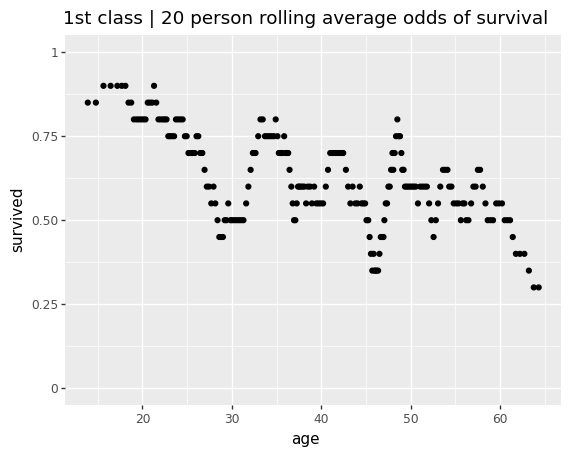

<ggplot: (505032345)>

In [ ]:
from plotnine import * 

(
ggplot(df[['age', 'survived','pclass']].query('pclass==1').dropna().sort_values(by='age').rolling(20, center=False).mean().dropna()) +
    geom_point(aes(x='age', y='survived')) +
    ylim(0,1) +
    ggtitle("1st class | 20 person rolling average odds of survival")
)

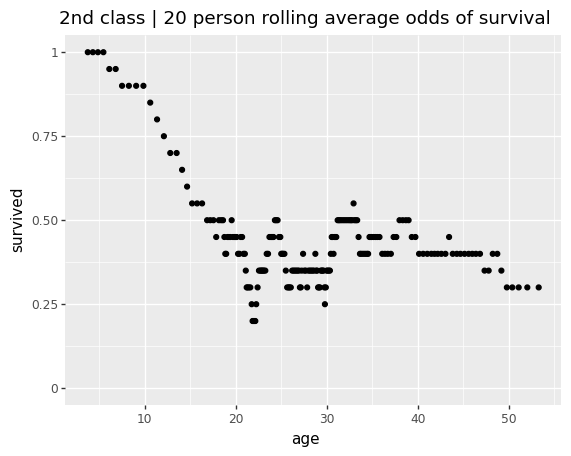

<ggplot: (285517893)>

In [ ]:
(
ggplot(df[['age', 'survived','pclass']].query('pclass==2').dropna().sort_values(by='age').rolling(20, center=False).mean().dropna()) +
    geom_point(aes(x='age', y='survived')) +
    ylim(0,1) +
    ggtitle("2nd class | 20 person rolling average odds of survival")
)

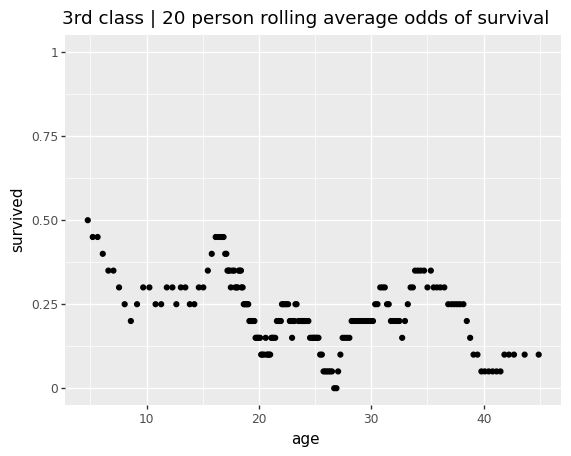

<ggplot: (508539773)>

In [ ]:
(
ggplot(df[['age', 'survived','pclass']].query('pclass==3').dropna().sort_values(by='age').rolling(20, center=False).mean().dropna()) +
    geom_point(aes(x='age', y='survived')) +
    ylim(0,1) +
    ggtitle("3rd class | 20 person rolling average odds of survival")
)

# What if I look at age as a binary?

In [ ]:

import statsmodels.formula.api as smf

model = smf.logit("survived ~ pclass + female + age<16", data=df)
results = model.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.430884
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  633
Model:                          Logit   Df Residuals:                      629
Method:                           MLE   Df Model:                            3
Date:                Wed, 26 Apr 2023   Pseudo R-squ.:                  0.3727
Time:                        11:49:02   Log-Likelihood:                -272.75
converged:                       True   LL-Null:                       -434.77
Covariance Type:            nonrobust   LLR p-value:                 6.210e-70
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5432      0.272      1.995      0.046       0.010       1.077
age < 16[T.True]     1.9827      0.376      5.273      0.000       1.246       2.720
pclass              -1.1394      0.148     -7.674      0.000      -1.430      -0.848
female               3.0906      0.241     12.845      0.000       2.619       3.562
====================================================================================
"""

In [ ]:

coefs = pd.DataFrame({
    'coef': results.params.values,
    'odds ratio': np.exp(results.params.values),
    'pvalue': results.pvalues,
    'name': results.params.index
})

coefs.round(2)

,coef,odds ratio,pvalue,name
Intercept,0.54,1.72,0.05,Intercept
age < 16[T.True],1.98,7.26,0.00,age < 16[T.True]
pclass,-1.14,0.32,0.00,pclass
female,3.09,21.99,0.00,female


This gives us a more explainable result.

# The story

- Sometimes you spend hours crafting the right sentence from the model
- Many times the model informs the story. For example, here are some headlines that could come of an analysis like this:
    - **Women and Children First** // Not everyone escaped on a lifeboat that tragic day
    - **The Rich Were Safer** // Passengers aboard the titanic who could afford to pay were more likely to be saved

Most of the time, the model isn't the story. It simply helps you to tell the story.

So we can ask ourselves if, in this case, talking about odds ratios or effect sizes makes the story more powerful, or needlessly distracts from the point? Can we go back to our simple pivot tables as we report out what exactly happened that day the titanic hit an iceberg?

In [ ]:
def categorize_age(age):
    if np.isnan(age):
        return 'unknown'
    
    if age<18:
        return 'child'
    else: 
        return 'adult'



df = pd.read_csv('titanic.csv')\
    .assign(
        child = lambda x: x.age.apply(categorize_age)
    )

df.pivot_table(
    columns='survived', index=['pclass', 'gender', 'child'], aggfunc='count', values='name', margins=True
).fillna(0).astype('int')

survived                 0    1   All
pclass gender child                  
1st    female adult      4   90    94
              child      1    6     7
              unknown    4   38    42
       male   adult     82   37   119
              child      0    6     6
              unknown   38   16    54
2nd    female adult     10   61    71
              child      0   14    14
              unknown    3   19    22
       male   adult    104   10   114
              child      2   11    13
              unknown   42    4    46
3rd    female adult     20   18    38
              child      9   10    19
              unknown  105   51   156
       male   adult    103   12   115
              child     17    6    23
              unknown  320   40   360
All                    864  449  1313